# Оценка результатов A/B-теста

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import scipy.stats as st
import requests

### Импортируем данные

In [59]:
studs_link = "https://disk.yandex.ru/d/zmJiYCj5LkV22g"
checks_link = "https://disk.yandex.ru/d/XX5KdKsNVfmcsw"
groups_link = "https://disk.yandex.ru/d/gQcz5hIGU-qCuQ"
group_add_link = "https://disk.yandex.ru/d/8ExWqAap39HGRQ"



#создаем универсальную функцию для чтения csv файлов

def load_csv_by_public_link(public_link, sep=';'):

    response = requests.get(
        "https://cloud-api.yandex.net/v1/disk/public/resources/download",
        params={"public_key": public_link}
    )
    if response.status_code != 200:
        raise Exception(f"Ошибка: {response.status_code}, {response.text}")
    
    download_url = response.json()["href"]
    return pd.read_csv(download_url, sep=sep)


studs = load_csv_by_public_link(studs_link)
checks = load_csv_by_public_link(checks_link)
groups = load_csv_by_public_link(groups_link)
group_add = load_csv_by_public_link(group_add_link, sep=',')



In [60]:
#файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента


studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [61]:
#файл с информацией об оплатах пользователей в дни проведения эксперимента. 

checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [62]:
# проверяем, есть ли в списке оплативших пользователи, которые не были активны в дни эксперимента

checks.query('student_id not in @studs.student_id')['student_id'].count()

149

In [63]:
# файл с информацией о принадлежности пользователя 
# к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

groups.head()


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [64]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [65]:
#соединяем 2 датафрейма - первоначальный, и который забыли отправить изначально 
# + переименовываем столбик id в student_id

groups_total=pd.concat([groups, group_add]).rename(columns={'id':'student_id'})

groups_total.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [66]:
# проверяем, нет ли пользователей, которые попали в обе группы

groups_total.groupby('student_id', as_index=False).agg({'grp':'count'}).sort_values('grp', ascending=False).head(5)

,student_id,grp
0,1489,1
49742,2711518,1
49722,2708589,1
49721,2708295,1
49720,2707985,1


In [67]:
# проверяем, что соединение прошло корректно

if groups_total['student_id'].count()==groups['id'].count()+group_add['id'].count():
    print("все ок")
else:
    print("что-то пошло не так")

все ок


### Сводим результаты эксперимента

Здесь для групп А и В посчитаем:

- Количество пользователей
- Количество и доля платящих клиентов
- Количество и доля не платящих клиентов
- Выручка на платящего пользователя

По полученным данным проверим, есть ли видимая разница между группами 

In [68]:
# сводим результаты эксперимента

exp_result=(
    
    
    # оставляем только тех пользователей, кто заходил на платформу во время проведедения эксперимента
    groups_total.query('student_id in @studs.student_id')
    
    
    # мерджим с датафреймом, содержащим информацию об оплатах. Ставим "left", потому что хотим учесть пользователей
    # которые заходили, но не платили
    .merge(checks, on='student_id', how='left')
    
    
    # группируем: A - контрольная группа, B - экспериментальная
    .groupby('grp', as_index=False)
    
    
    # в агрегации считаем: прибыль внутри группы, кол-во пользователей, 
    # не совершавших какие-либо оплаты, количество пользователей в группе в целом)
    .agg(students_total=('student_id', 'count'),
         rev_total=('rev', 'sum'),
         students_not_paying=('rev', lambda x: x.isna().sum()))
                  

        ) 

In [69]:
#Рассчитываем дополнительные метрики

# Доля неплатящих
exp_result['students_not_paying_ratio']=exp_result['students_not_paying']/exp_result['students_total']*100

# Кол-во платящих
exp_result['paying_students']=round(exp_result['students_total']-exp_result['students_not_paying'], 2)

# Доля платящих
exp_result['paying_students_ratio']=round(exp_result['paying_students']/exp_result['students_total']*100, 2)

# Средняя выручка с платящего
exp_result['ARPPU']=round(exp_result['rev_total']/(exp_result['students_total']-exp_result['students_not_paying']), 2)


In [70]:
exp_result

,grp,students_total,rev_total,students_not_paying,students_not_paying_ratio,paying_students,paying_students_ratio,ARPPU
0,A,1538,72820.0000,1460.0,94.928479,78.0,5.07,933.59
1,B,6803,394974.0035,6489.0,95.384389,314.0,4.62,1257.88


### Проверка статзначимости различий

Видим, что доля платящих пользователей в экспериментальной группе меньше, при этом выручка больше.

Проверим, насколько эти различия являются статистически значимыми.

In [71]:
# Проверим разницу в доле платящих с помощью Хи квадрата проверим


stat_diff_paying_ratio=exp_result[['students_not_paying_ratio', 'paying_students_ratio']]
stat_diff_paying_ratio

chi2, p, dof, expected = st.chi2_contingency(stat_diff_paying_ratio)

print(f"Хи-квадрат статистика: {chi2}")
print(f"P-значение: {p}")

alpha = 0.05
if p < alpha:
    print("Новая форма оплаты повлияла на долю платящих пользователей")
else:
    print("Новая форма оплаты не отразилась на доле платящих пользователей")

Хи-квадрат статистика: 0.0
P-значение: 1.0
Новая форма оплаты не отразилась на доле платящих пользователей


#### Подготовим данные для сравнения результатов по оплатам в двух группах

In [83]:
#формируем общий датафрейм с оплатами 

group_paid=groups_total.merge(checks, on='student_id', how='inner')


#формируем отдельные датафреймы с выручкой для групп А и В (исключая неплатящих пользователей)

group_a=groups_total.query('grp=="A"').merge(checks, on='student_id', how='inner')

group_b=groups_total.query('grp=="B"').merge(checks, on='student_id', how='inner')

#### Проверим распределение в обеих группах

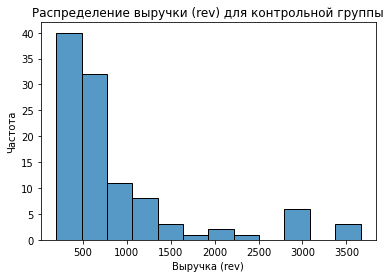

p-value = 4.580439316510776e-12, распределение НЕ является нормальным


In [84]:
#строим график распределения для контрольной группы 
sns.histplot(group_a['rev'])

# Оформление графика
plt.title("Распределение выручки (rev) для контрольной группы")
plt.xlabel("Выручка (rev)")
plt.ylabel("Частота")
plt.show()

#выводим результаты теста на нормальность распределения

stat, p_value = st.normaltest(group_a['rev'])


if p_value < 0.05:
    print(f"p-value = {p_value}, распределение НЕ является нормальным")
else:
    print(f"p-value = {p_value}, распределение является нормальным")

In [85]:
# Группа A: топ оплат

group_a.groupby('rev', as_index=False).agg({'student_id':'count'}).rename({'student_id':'payments'}).sort_values('student_id', ascending=False).head(5)

,rev,student_id
1,290.0,31
6,690.0,19
0,199.0,7
9,990.0,6
4,580.0,6


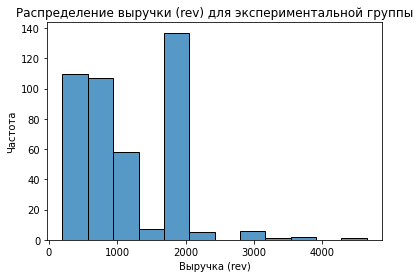

p-value = 6.18881394639434e-08, распределение НЕ является нормальным


In [86]:
#строим график распределения для экспериментальной группы 
sns.histplot(group_b['rev'])

# Оформление графика

plt.title("Распределение выручки (rev) для экспериментальной группы")
plt.xlabel("Выручка (rev)")
plt.ylabel("Частота")
plt.show()


# выводим результаты теста на нормальность распределения

stat, p_value = st.normaltest(group_b['rev'])


if p_value < 0.05:
    print(f"p-value = {p_value}, распределение НЕ является нормальным")
else:
    print(f"p-value = {p_value}, распределение является нормальным")

In [87]:
# Группа В: топ оплат

group_b.groupby('rev', as_index=False).agg({'student_id':'count'}).rename({'student_id':'payments'}).sort_values('student_id', ascending=False).head(5)

,rev,student_id
22,1900.0000,97
1,290.0000,63
8,690.0000,59
0,199.0000,39
23,1900.0001,36


#### Проверим дисперсии в группах

In [88]:
stat, p_value = st.levene(group_a['rev'], group_b['rev'])

print(f"Levene test stat = {stat:.4f}, p = {p_value:.4f}")

if p_value < 0.05:
    print(" Дисперсии значимо различаются")
else:
    print(" Дисперсии примерно равны")

Levene test stat = 4.4789, p = 0.0348
 Дисперсии значимо различаются


#### Используем тест Колмогорова - Смирнова для сравнения двух групп

In [98]:
#проверяем, являются ли различия статистически значимыми

from scipy.stats import ks_2samp

stat, p_value = ks_2samp(group_a['rev'], group_b['rev'])

print(f"U-статистика: {stat}")
print(f"P-значение: {p_value:.5f} ")

if p_value < 0.05:
    print("Распределения в группах разные — то есть отличаются по форме и положению")
else:
    print("Распределения в группах одинаковы — то есть совпадают по форме и положению")


U-статистика: 0.24432576769025366
P-значение: 0.00005 
Распределения в группах разные — то есть отличаются по форме и положению


#### Так как дисперсии различаются, распределение ненормальное НО выборка достаточно большая, то для проверки статзначимости различий используем T-тест Уэлча.

In [96]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(group_a['rev'], group_b['rev'], equal_var=False)

print(f"Welch's t-статистика: {t_stat:.4f}")
print(f"P-значение: {p_val:.4f}")



if p_val < 0.05:
    print("Различия статистически значимы")
else:
    print("Нет статистически значимых различий")

Welch's t-статистика: -2.8670
P-значение: 0.0047
Различия статистически значимы


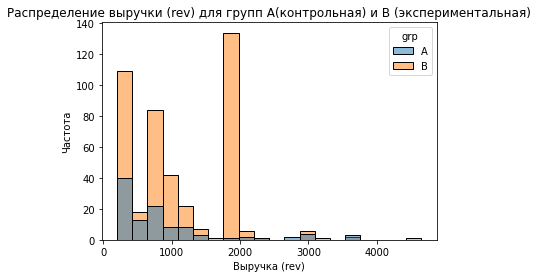

In [90]:
#строим общий график распределения 

sns.histplot(group_paid, hue='grp', x='rev', bins=20)

# Оформление графика
plt.title("Распределение выручки (rev) для групп А(контрольная) и В (экспериментальная)")
plt.xlabel("Выручка (rev)")
plt.ylabel("Частота")
plt.show()

In [92]:
difference=round(((exp_result.query('grp=="B"')['ARPPU'].values[0]-exp_result.query('grp=="A"')['ARPPU']).values[0]/exp_result.query('grp=="A"')['ARPPU'].values[0])*100, 2)

if p_value < 0.05 and exp_result.query('grp=="A"')['ARPPU'].values[0] < exp_result.query('grp=="B"')['ARPPU'].values[0]:
    print( f"Нововведение позволило увеличить ARPPU на {difference}%")
    
elif p_value < 0.05 and exp_result.query('grp=="A"')['ARPPU'].values[0] > exp_result.query('grp=="B"')['ARPPU'].values[0]:
    print( f"Нововведение способствовало снижению ARPPU на {difference}%")
    
else:
    print("Нововведение не повлияло на ARPU")

Нововведение позволило увеличить ARPPU на 34.74%


## Выводы и рекомендации

Мы провели А/В-тест новой механики оплаты на сайте и проанализировали изменения в доле платящих пользователей и ARPPU.

Нововведение не повлияла на долю платящих пользователей.
Однако мы видим существенное увеличение выручки с платящих пользователей - ARPPU выросла на 34.74%. 
Рост произошел за счет прироста покупки услуги стоимостью 1900: в экспериментальной группе она вырывается в топ трат.

Рекомендуем запустить новую механику оплаты на всех пользователей. 

##### Судя по результатам могу предположить, что введена механика оплаты вроде кредита или сплита (так как произошел всплеск покупок предположительно одной высокостоящей услуги). В таком случае можно дополнительно отметить, что данную механику можно использовать не для всех услуг в приложении, но для более дорогостоящих (меньше рисков и издержек для компании).

________